# **Numerical Experiments for Exact models**

In [1]:
import sys

sys.path.insert(0,"./../tests/numerical") # clue_example is here
sys.path.insert(0,"./../") # clue is here

from clue import *
from numerical_example import *
from sympy import RR
import pandas as pd
import time
from alive_progress import alive_bar

import logging
logger = logging.getLogger("clue")
# logger.setLevel(logging.DEBUG)

In [15]:
def analysis_epsilon(example, num_points = 1000, threshold = 1e-6, mid_points=50):
    ## Reading the system
    logger.info(f"[analysis_epsilon # {example.name}] Starting epsilon analysis for {example.name}")
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
    RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
    x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
    norm_x0 = norm(x0, ord=2)
    
    ## Creating the matrices for lumping
    logger.info(f"[analysis_epsilon # {example.name}] Building matrices for lumping...")
    system.construct_matrices(example.matrix)
    RRsystem._lumping_matr.update({k: tuple([M.change_base(RR) for M in v]) for (k,v) in system._lumping_matr.items()})
    
    ## Processing observables
    logger.info(f"[analysis_epsilon # {example.name}] Building observables...")
    observables = [[SparsePolynomial.from_string(obs, RRsystem.variables, RRsystem.field) for obs in observable] for observable in example.observables]
    ORR = [tuple([obs.linear_part_as_vec().change_base(RR) for obs in observable]) for observable in observables]
    
    ## Processing the bound for sampling 
    logger.info(f"[analysis_epsilon # {example.name}] Processing bound for sampling...")
    bound = RRsystem._FODESystem__process_bound(norm_x0, threshold)
    
    ## Gathering data
    all_data = []
    for observable, O in zip(observables, ORR):
        logger.info(f"[analysis_epsilon # {example.name}] Computing data for {observable}...")
        max_epsilon, max_deviation = RRsystem.find_maximal_threshold(observable, bound, num_points, threshold, matrix_algorithm=example.matrix);
        max_epsilon, max_deviation
        eps_vs_devs = []
        ## First iteration is the exact lumping
        subspace = find_smallest_common_subspace(system.construct_matrices(example.matrix), tuple(M.change_base(system.field) for M in O), OrthogonalSubspace)
        deviation = RRsystem._deviation(subspace, bound, num_points)
        eps_vs_devs.append((0.0, deviation, subspace))
        ## Other iterations use the numerical lumping
        for i in range(1,mid_points+1):
            epsilon = max_epsilon * (i/(mid_points-1))
            subspace = find_smallest_common_subspace(RRsystem.construct_matrices(example.matrix), O, NumericalSubspace, delta=epsilon)
            deviation = RRsystem._deviation(subspace, bound, num_points)
            eps_vs_devs.append((epsilon, deviation, subspace))
        all_data.append([eps_vs_devs, max(el[1] for el in eps_vs_devs), (system.size, eps_vs_devs[0][2].dim())])
                
    ## Generating graphics
    logger.info(f"[analysis_epsilon # {example.name}] Generating graphics...")
    graphs, titles = [], []
    for obs, (eps_vs_devs, mdev, (osize,lsize)) in zip(example.observables, all_data):
        x_axis = array([el[0] for el in eps_vs_devs])
        data = array([[el[1]/mdev if mdev != 0 else 0, el[2].dim()/lsize] for el in eps_vs_devs]).transpose()
        graphs.append(OdeResult(t=x_axis, y=data, success=True, names=["deviation", "(num size)/(exact size)"]))
        titles.append(f"Lumping evolution for {str(obs) if len(str(obs)) < 100 else 'something'} ({osize}->{lsize})")
        
    fig = create_figure(graphs, title=titles)
    
    logger.info(f"[analysis_epsilon # {example.name}] Finidhes execution for {example.name}")
    return all_data

## Some example lines

In [6]:
## This line can run an example just providing the name of the example
run_exact("ProteinPhosphorylation[2]")

2023-03-15 14:39:19 Level 60 [run_exact] Reading the system both exactly and numerical
2023-03-15 14:39:19 Level 60 [run_exact] Removing the parameters of the system
2023-03-15 14:39:19 Level 60 [run_exact] Obtaining the initial condition from the system
2023-03-15 14:39:19 Level 60 [run_exact] Initial state of the problem: ||x_0|| = 3029.8630315576975 -- ||f(x_0)|| = 1992234.925906079
2023-03-15 14:39:19 Level 60 [run_exact] Computing numerical simulation for the exact system (t0=0.0,t1=0.00125,tstep=6.25e-06)
2023-03-15 14:39:21 Level 60 [run_exact] Building observables
2023-03-15 14:39:21 Level 60 [run_exact] Computing the exact lumping for each observable
2023-03-15 14:39:21 Level 60 [run_exact] Creating the result structures
2023-03-15 14:39:21 Level 60 [run_exact] Running each of the cases
2023-03-15 14:39:21 Level 60 [run_exact] Computing (if needed) epsilon for ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 100.0% slope = 1992234.925906079) [S0, S1

In [2]:
## This line can compile all the executed examples
compile_results()

2023-03-15 14:40:44 Level 60 [compile_results] Compiling results for ProteinPhosphorylation[2] with read='polynomial' and matrix='polynomial'...
2023-03-15 14:40:44 INFO     [from_file] Read case ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 100.0% slope = 1992234.925906079) [S0, S1]
2023-03-15 14:40:44 INFO     [from_file] Read case ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 1000.0% slope = 19922349.25906079) [S0, S1]
2023-03-15 14:40:44 INFO     [from_file] Read case ProteinPhosphorylation[2] (r=polynomial,m=polynomial) (C=3029.8630315576975; 10000.0% slope = 199223492.59060788) [S0, S1]
2023-03-15 14:40:44 Level 60 [compile_results] Compiling results for BioNetGen_CCP with read='polynomial' and matrix='polynomial'...
2023-03-15 14:40:44 INFO     [from_file] Read case BioNetGen_CCP (r=polynomial,m=polynomial) (C=1.0; 10.0% slope = 0.1) [s18 + s40]
2023-03-15 14:40:44 INFO     [from_file] Read case BioNetGen_CCP (r=polyn

In [26]:
## We can read the results using this line
compilation = pd.read_csv('../tests/numerical/compilation.csv', sep=';')
compilation

,modelName,type,maxPerturbation,size,clum_size,nlum_size,et_rel,et,|M*xt|_2,epsilon,...,avg_per_err,avg_err,max_err,max_epsilon,consideredEpsilons,tolerance,t0,t1,secThisEpsilon,secTotal
0,"ProteinPhosphorylation[2]_[S0, S1]_[e=0.250]",polynomial,0.0,24,12,12,0.000035,0.000262,7.533553,2.500000e-01,...,0.038805,0.000263,0.002471,3.162278e+00,1,0.000001,0.0,20.00000,0.00000,0.155570
1,"ProteinPhosphorylation[2]_[S0, S1]_[e=0.750]",polynomial,0.0,24,12,10,0.116661,0.878873,7.533553,7.500000e-01,...,3.713440,0.606794,21.653997,3.162278e+00,1,0.000001,0.0,20.00000,0.00000,0.136096
2,"ProteinPhosphorylation[2]_[S0, S1]_[e=2.000]",polynomial,0.0,24,12,8,55.551017,418.496513,7.533553,2.000000e+00,...,23539.707760,291.609364,300.001607,3.162278e+00,1,0.000001,0.0,20.00000,0.00000,0.111954
3,BioNetGen_CCP_[s18 + s40]_[e=0.106],polynomial,0.0,87,30,30,0.000002,0.000024,10.418271,1.055485e-01,...,0.004552,0.000198,0.000660,2.828427e+00,23,0.000001,0.0,100.00000,25.90354,31.556444
4,BioNetGen_CCP_[s18 + s40]_[e=0.106],polynomial,0.0,87,30,28,0.186261,1.940516,10.418271,1.060657e-01,...,11.733550,1.178022,1.940632,2.828427e+00,23,0.000001,0.0,100.00000,9.95547,13.812583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,"BIOMD0000000634_[GSK3b, ROS, Tau]_[e=10000.000]",rational,0.0,68,64,56,0.000781,0.389068,497.858920,1.000000e+04,...,20.956884,0.064068,0.389068,7.500000e+10,1,0.000001,0.0,0.00025,0.00000,1.301341
86,"BIOMD0000000634_[GSK3b, ROS, Tau]_[e=100000.000]",rational,0.0,68,64,50,0.000781,0.389068,497.858920,1.000000e+05,...,20.956884,0.064068,0.389068,7.500000e+10,1,0.000001,0.0,0.00025,0.00000,1.167135
87,"BIOMD0000000634_[GSK3b, ROS, Tau]_[e=1000000.000]",rational,0.0,68,64,43,0.000781,0.389068,497.858920,1.000000e+06,...,20.956884,0.064068,0.389068,7.500000e+10,1,0.000001,0.0,0.00025,0.00000,1.012565
88,"BIOMD0000000634_[GSK3b, ROS, Tau]_[e=10000000....",rational,0.0,68,64,13,0.004301,2.141081,497.858920,1.000000e+07,...,1578.339225,0.500403,2.141081,7.500000e+10,1,0.000001,0.0,0.00025,0.00000,0.412807


## Exploring limits for some example

### ProteinPhosphorylation[2]

In [20]:
example = get_example("ProteinPhosphorylation[2]")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 24
Initial state: |x_0| = 3029.8630315576975 ## |f(x_0)| = 1992234.925906079


#### Checking time for simulation

In [7]:
## Defining time frame
t0 = 0.0; t1 = 20.0; tstep = (t1-t0)/200

In [8]:
%time simulation = system.simulate(t0,t1,x0,tstep)

CPU times: user 7.47 s, sys: 0 ns, total: 7.47 s
Wall time: 7.47 s


CPU times: user 3.75 ms, sys: 19.2 ms, total: 22.9 ms
Wall time: 21.9 ms


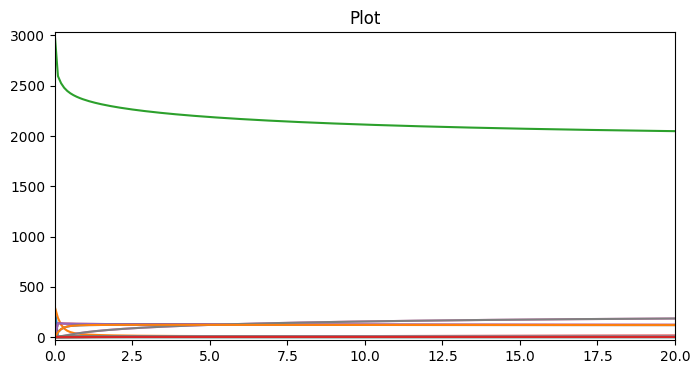

In [9]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking different epsilons

2023-03-28 11:32:29 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Starting epsilon analysis for ProteinPhosphorylation[2]
2023-03-28 11:32:29 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Building matrices for lumping...
2023-03-28 11:32:29 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Building observables...
2023-03-28 11:32:29 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Processing bound for sampling...
2023-03-28 11:32:29 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Computing data for [S0, S1]...
2023-03-28 11:32:33 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Generating graphics...
2023-03-28 11:32:33 INFO     [analysis_epsilon # ProteinPhosphorylation[2]] Finidhes execution for ProteinPhosphorylation[2]


CPU times: user 4.19 s, sys: 0 ns, total: 4.19 s
Wall time: 4.18 s


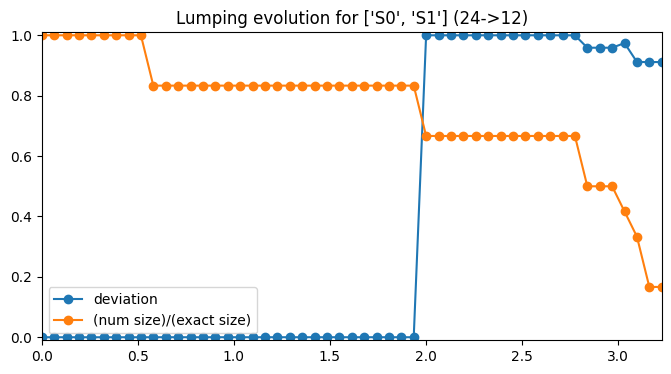

In [21]:
%time data = analysis_epsilon(get_example("ProteinPhosphorylation[2]"))

### BioNetGen

In [16]:
example = get_example("BioNetGen_CCP")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 87
Initial state: |x_0| = 1.0 ## |f(x_0)| = 1.0


#### Checking time for simulation

In [146]:
## Defining time frame
t0 = 0.0; t1 = 100.0; tstep = (t1-t0)/200

In [147]:
%time simulation = system.simulate(t0,t1,x0,tstep)

CPU times: user 301 ms, sys: 10 ms, total: 311 ms
Wall time: 308 ms


CPU times: user 33.7 ms, sys: 0 ns, total: 33.7 ms
Wall time: 33.1 ms


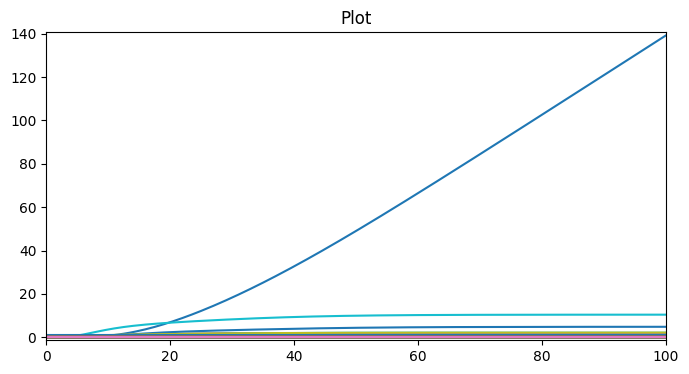

In [148]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-28 11:29:52 INFO     [analysis_epsilon # BioNetGen_CCP] Starting epsilon analysis for BioNetGen_CCP
2023-03-28 11:29:52 INFO     [analysis_epsilon # BioNetGen_CCP] Building matrices for lumping...
2023-03-28 11:29:52 INFO     [analysis_epsilon # BioNetGen_CCP] Building observables...
2023-03-28 11:29:52 INFO     [analysis_epsilon # BioNetGen_CCP] Processing bound for sampling...
2023-03-28 11:29:52 INFO     [analysis_epsilon # BioNetGen_CCP] Computing data for [s18 + s40]...
2023-03-28 11:30:16 INFO     [analysis_epsilon # BioNetGen_CCP] Computing data for [s0 + s34]...
2023-03-28 11:30:19 INFO     [analysis_epsilon # BioNetGen_CCP] Computing data for [s1 + s66 + s67 + s68]...
2023-03-28 11:30:55 INFO     [analysis_epsilon # BioNetGen_CCP] Computing data for [s2 + s36]...
2023-03-28 11:30:58 INFO     [analysis_epsilon # BioNetGen_CCP] Computing data for [s3 + s43]...
2023-03-28 11:31:39 INFO     [analysis_epsilon # BioNetGen_CCP] Generating graphics...
2023-03-28 11:31:39 INFO 

CPU times: user 1min 46s, sys: 274 ms, total: 1min 47s
Wall time: 1min 46s


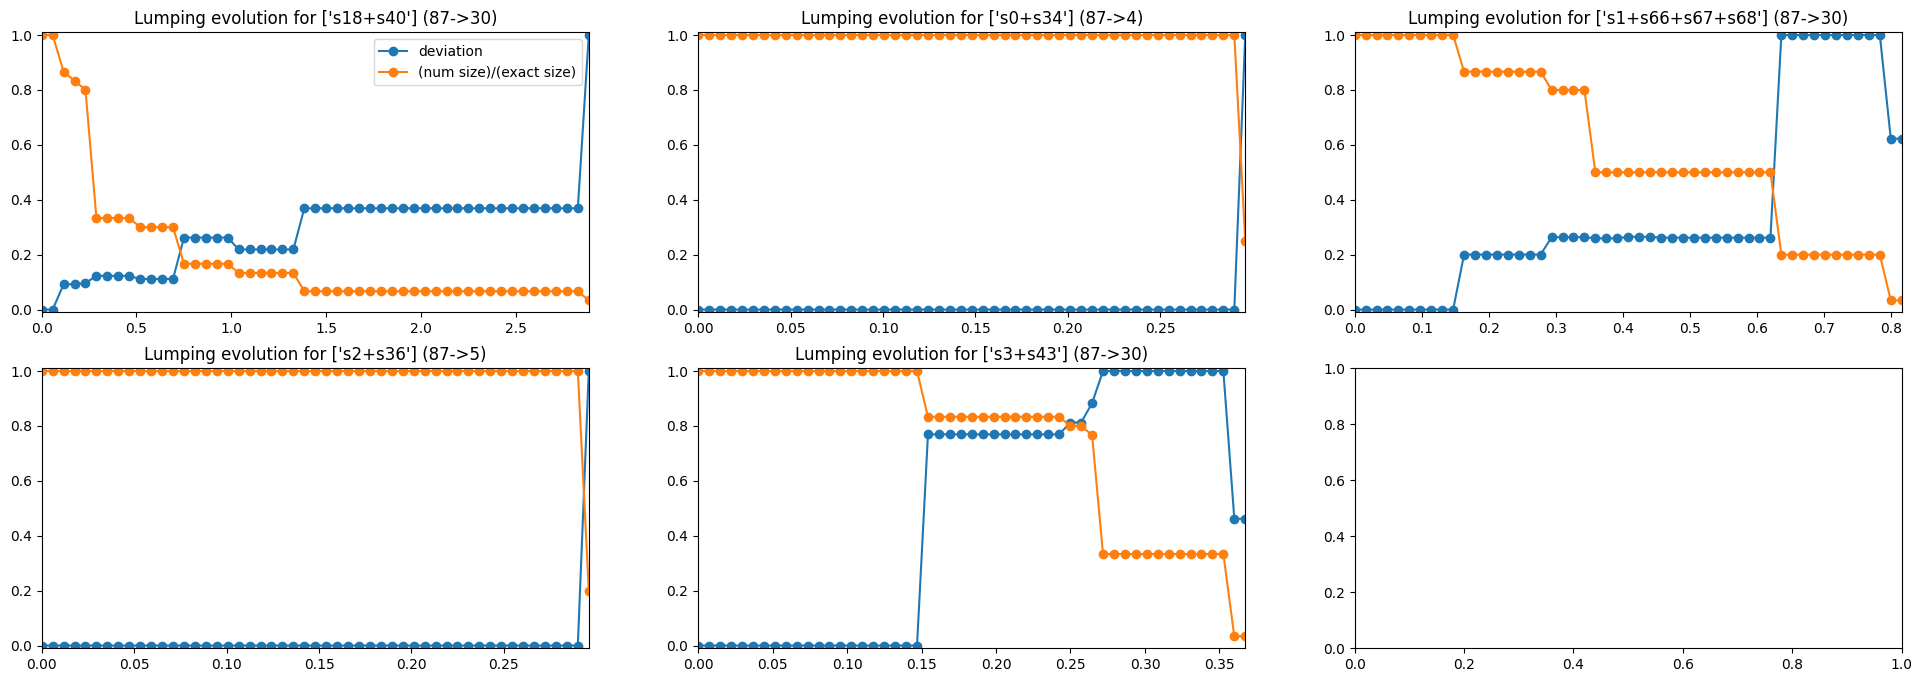

In [17]:
%time data = analysis_epsilon(get_example("BioNetGen_CCP"))

### BIO...013  ($t_1 = 0.4$)

In [13]:
example = get_example("BIOMD0000000013")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 27
Initial state: |x_0| = 5.824618359277371 ## |f(x_0)| = 1601262019.543335


#### Checking time for simulation

In [17]:
## Defining time frame
t0 = 0.0; t1 = 0.4; tstep = (t1-t0)/200; print(t1)

0.4


In [27]:
%time simulation = system.simulate(t0,t1,x0,tstep,method="LSODA")

CPU times: user 133 ms, sys: 10 ms, total: 143 ms
Wall time: 141 ms


CPU times: user 12.7 ms, sys: 10.2 ms, total: 22.9 ms
Wall time: 22.1 ms


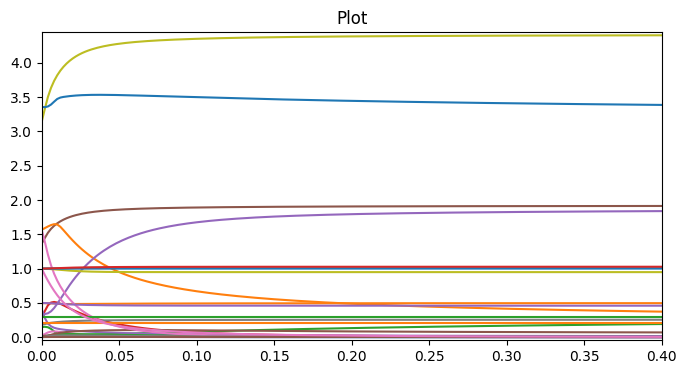

In [28]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 11:44:43 INFO     [analysis_epsilon # BIOMD0000000013] Starting epsilon analysis for BIOMD0000000013
2023-03-21 11:44:43 INFO     [analysis_epsilon # BIOMD0000000013] Building matrices for lumping...
2023-03-21 11:45:50 INFO     [analysis_epsilon # BIOMD0000000013] Building matrices for lumping...
2023-03-21 11:45:50 INFO     [analysis_epsilon # BIOMD0000000013] Processing bound for sampling...
2023-03-21 11:45:50 INFO     [analysis_epsilon # BIOMD0000000013] Computing data for [x_CO2]...
2023-03-21 11:45:50 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 11:45:50 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: divide by zero encountered in double_scalars
2023-03-21 11:45:53 INFO     [analysis_epsilon # BIOMD0000000013] Generating graphics...


CPU times: user 1min 10s, sys: 90.2 ms, total: 1min 10s
Wall time: 1min 10s


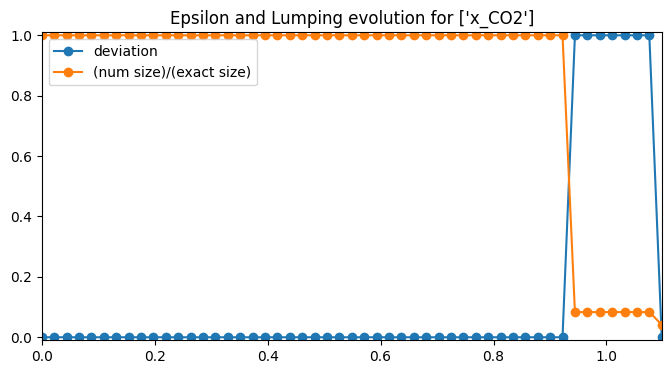

In [6]:
%time data = analysis_epsilon(get_example("BIOMD0000000013"))

### BIO...023 ($t_1 = 20$)

In [29]:
example = get_example("BIOMD0000000023")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 13
Initial state: |x_0| = 9.060353193998564 ## |f(x_0)| = 2.6939399505014583


#### Checking time for simulation

In [30]:
## Defining time frame
t0 = 0.0; t1 = 20.0; tstep = (t1-t0)/200

In [31]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 9.85 ms, sys: 0 ns, total: 9.85 ms
Wall time: 10.1 ms


CPU times: user 16 ms, sys: 19 µs, total: 16 ms
Wall time: 15.3 ms


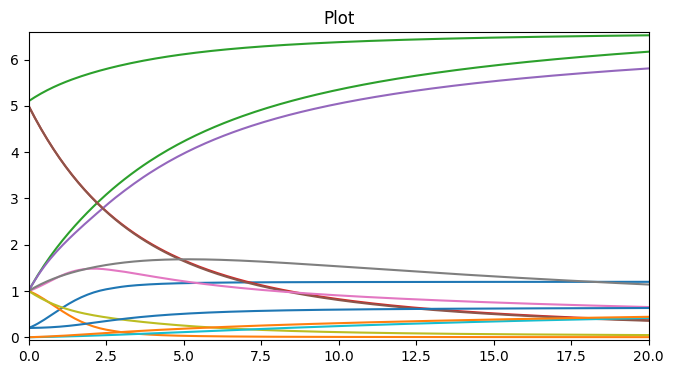

In [32]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 11:47:06 INFO     [analysis_epsilon # BIOMD0000000023] Starting epsilon analysis for BIOMD0000000023
2023-03-21 11:47:06 INFO     [analysis_epsilon # BIOMD0000000023] Building matrices for lumping...
2023-03-21 11:47:08 INFO     [analysis_epsilon # BIOMD0000000023] Building matrices for lumping...
2023-03-21 11:47:08 INFO     [analysis_epsilon # BIOMD0000000023] Processing bound for sampling...
2023-03-21 11:47:08 INFO     [analysis_epsilon # BIOMD0000000023] Computing data for [Fru]...
2023-03-21 11:47:08 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 11:47:08 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
2023-03-21 11:47:08 INFO     [analysis_epsilon # BIOMD0000000023] Generating graphics...
2023-03-21 11:47:08 INFO     [analysis_epsilon # BIOMD0000000023] Finidhes execution for BIOMD0000000023


CPU times: user 2.1 s, sys: 67 µs, total: 2.1 s
Wall time: 2.09 s


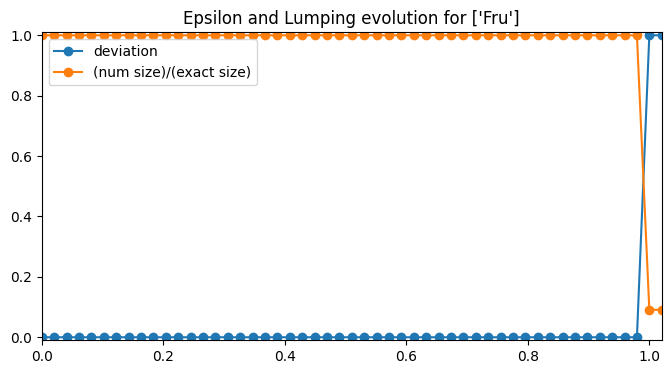

In [7]:
%time data = analysis_epsilon(get_example("BIOMD0000000023"))

### BIO...033 ($t_1 = ~5\cdot 10^{-8}$)

In [2]:
example = get_example("BIOMD0000000033")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 32
Initial state: |x_0| = 10057914.29671182 ## |f(x_0)| = 2.4231020548070703e+19


#### Checking time for simulation

In [30]:
## Defining time frame
t0 = 0.0; t1 = 0.00000003; tstep = (t1-t0)/200; print(t1)

3e-08


In [31]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 3.99 s, sys: 88 µs, total: 3.99 s
Wall time: 3.99 s


CPU times: user 20.1 ms, sys: 2 µs, total: 20.1 ms
Wall time: 19.4 ms


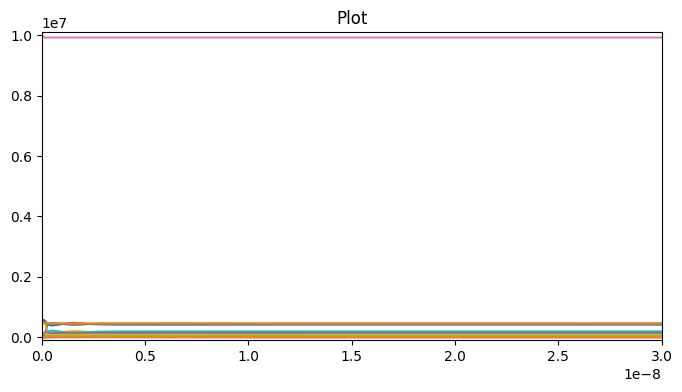

In [32]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 12:47:32 INFO     [analysis_epsilon # BIOMD0000000033] Starting epsilon analysis for BIOMD0000000033
2023-03-21 12:47:33 INFO     [analysis_epsilon # BIOMD0000000033] Building matrices for lumping...
2023-03-21 12:48:00 INFO     [analysis_epsilon # BIOMD0000000033] Building matrices for lumping...
2023-03-21 12:48:00 INFO     [analysis_epsilon # BIOMD0000000033] Processing bound for sampling...
2023-03-21 12:48:00 INFO     [analysis_epsilon # BIOMD0000000033] Computing data for [freeEGFReceptor]...
2023-03-21 12:48:00 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 12:48:00 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
2023-03-21 12:48:00 INFO     [analysis_epsilon # BIOMD0000000033] Generating graphics...
2023-03-21 12:48:00 INFO     [analysis_epsilon # BIOMD0000000033] Finidhes execution for BIOMD0000000033


CPU times: user 28.1 s, sys: 9.94 ms, total: 28.1 s
Wall time: 28.1 s


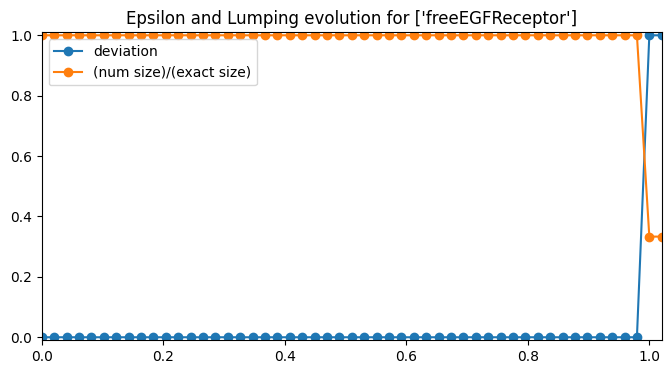

In [35]:
%time data = analysis_epsilon(get_example("BIOMD0000000033"))

### BIO...113 ($t_1 = 1$)

In [33]:
example = get_example("BIOMD0000000113")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 6
Initial state: |x_0| = 2.1406774628607645 ## |f(x_0)| = 6.889146250310192


#### Checking time for simulation

In [40]:
## Defining time frame
t0 = 0.0; t1 = 1; tstep = (t1-t0)/200

In [41]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 27.9 ms, sys: 0 ns, total: 27.9 ms
Wall time: 26.8 ms


CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 18.2 ms


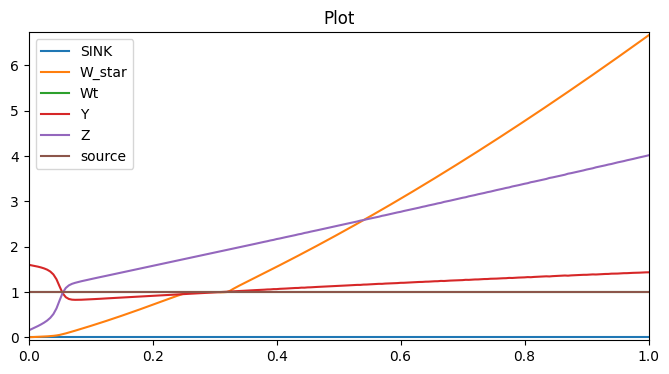

In [42]:
%time fig = create_figure(simulation, legend=True, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Starting epsilon analysis for BIOMD0000000113
2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Building matrices for lumping...
2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Building matrices for lumping...
2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Processing bound for sampling...
2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Computing data for [Y]...
2023-03-21 11:50:07 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 11:50:07 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Generating graphics...
2023-03-21 11:50:07 INFO     [analysis_epsilon # BIOMD0000000113] Finidhes execution for BIOMD0000000113


CPU times: user 294 ms, sys: 40 µs, total: 294 ms
Wall time: 294 ms


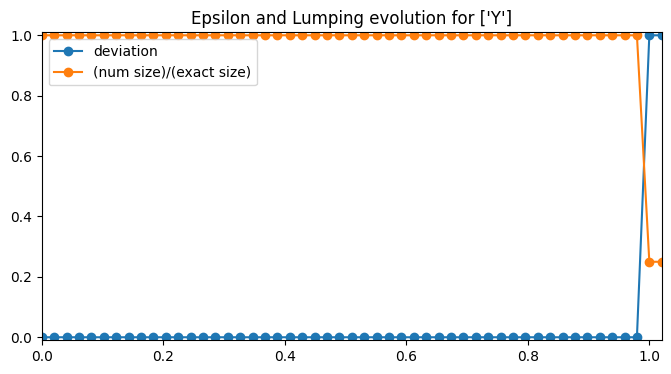

In [8]:
%time data = analysis_epsilon(get_example("BIOMD0000000113"))

### BIO...182 ($t_1 = 0.01$)(lumping slow)

In [73]:
example = get_example("BIOMD0000000182")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 36
Initial state: |x_0| = 4256787.674822413 ## |f(x_0)| = 12708187010.319235


#### Checking time for simulation

In [74]:
## Defining time frame
t0 = 0.0; t1 = 0.01; tstep = (t1-t0)/200; print(t1)

0.01


In [75]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 691 ms, sys: 0 ns, total: 691 ms
Wall time: 691 ms


CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 24.7 ms


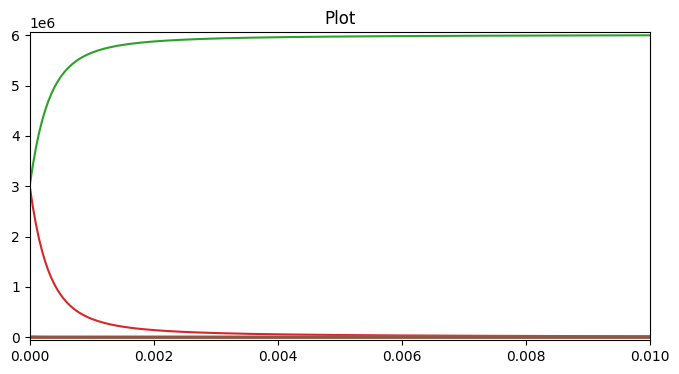

In [76]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 12:04:07 INFO     [analysis_epsilon # BIOMD0000000182] Starting epsilon analysis for BIOMD0000000182
2023-03-21 12:04:07 INFO     [analysis_epsilon # BIOMD0000000182] Building matrices for lumping...
2023-03-21 12:12:54 INFO     [analysis_epsilon # BIOMD0000000182] Building matrices for lumping...
2023-03-21 12:12:54 INFO     [analysis_epsilon # BIOMD0000000182] Processing bound for sampling...
2023-03-21 12:12:54 INFO     [analysis_epsilon # BIOMD0000000182] Computing data for [AC_cyto_mem]...
2023-03-21 12:12:54 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 12:12:54 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
2023-03-21 12:12:55 INFO     [analysis_epsilon # BIOMD0000000182] Generating graphics...
2023-03-21 12:12:55 INFO     [analysis_epsilon # BIOMD0000000182] Finidhes execution for BIOMD0000000182


CPU times: user 8min 48s, sys: 59.9 ms, total: 8min 48s
Wall time: 8min 48s


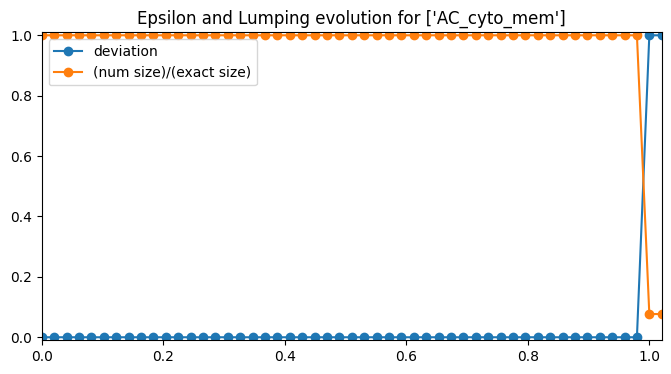

In [15]:
%time data = analysis_epsilon(get_example("BIOMD0000000182")) # More than 40 mins

### BIO...313 ($t_1=2$)

In [77]:
example = get_example("BIOMD0000000313")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 17
Initial state: |x_0| = 219.8375018871894 ## |f(x_0)| = 24.32356322749757


#### Checking time for simulation

In [84]:
## Defining time frame
t0 = 0.0; t1 = 2.0; tstep = (t1-t0)/200

In [85]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 4.68 ms, sys: 0 ns, total: 4.68 ms
Wall time: 4.28 ms


CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 16.9 ms


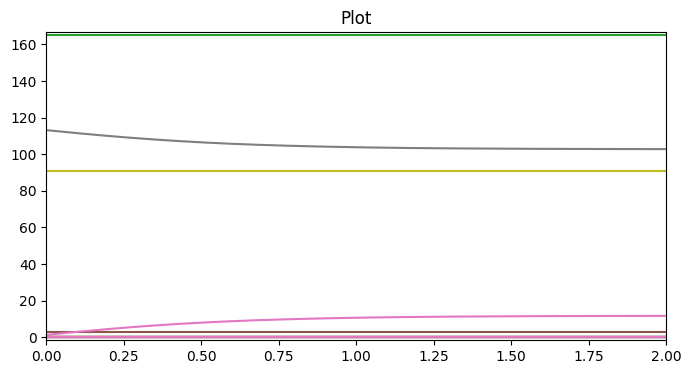

In [86]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 11:51:15 INFO     [analysis_epsilon # BIOMD0000000313] Starting epsilon analysis for BIOMD0000000313
2023-03-21 11:51:16 INFO     [analysis_epsilon # BIOMD0000000313] Building matrices for lumping...
2023-03-21 11:51:16 INFO     [analysis_epsilon # BIOMD0000000313] Building matrices for lumping...
2023-03-21 11:51:16 INFO     [analysis_epsilon # BIOMD0000000313] Processing bound for sampling...
2023-03-21 11:51:16 INFO     [analysis_epsilon # BIOMD0000000313] Computing data for [IL13_DecoyR]...
2023-03-21 11:51:16 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 11:51:16 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
2023-03-21 11:51:16 INFO     [analysis_epsilon # BIOMD0000000313] Generating graphics...
2023-03-21 11:51:16 INFO     [analysis_epsilon # BIOMD0000000313] Finidhes execution for BIOMD0000000313


CPU times: user 937 ms, sys: 40 µs, total: 937 ms
Wall time: 937 ms


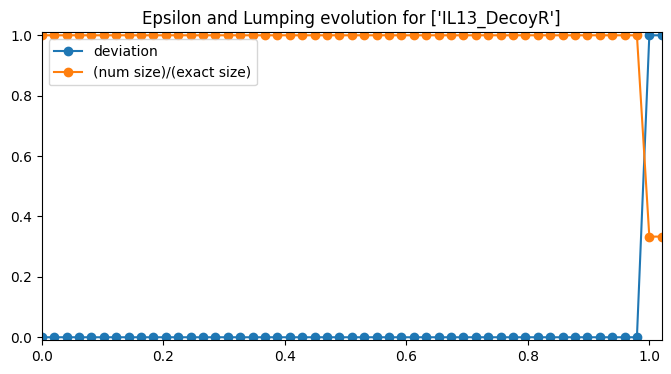

In [11]:
%time data = analysis_epsilon(get_example("BIOMD0000000313"))

### BIO...448 ($t_1 = 0.0001$)

In [18]:
example = get_example("BIOMD0000000448")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 27
Initial state: |x_0| = 285.97887054252095 ## |f(x_0)| = 121558889085.96109


#### Checking time for simulation

In [100]:
## Defining time frame
t0 = 0.0; t1 = 1e-4; tstep = (t1-t0)/200; print(t1)

0.0001


In [101]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 16.4 s, sys: 5.04 ms, total: 16.5 s
Wall time: 16.4 s


CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 21.8 ms


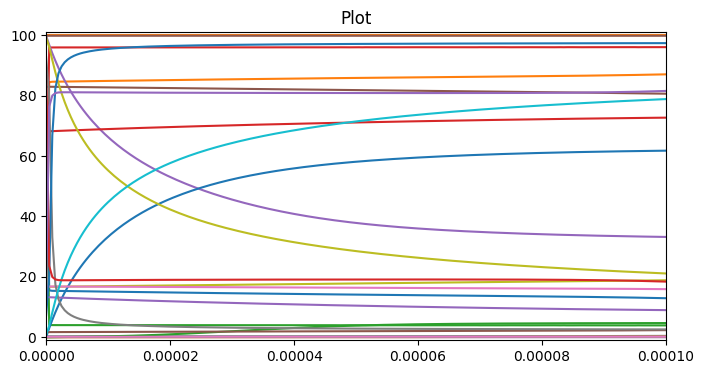

In [102]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-28 11:32:06 INFO     [analysis_epsilon # BIOMD0000000448] Starting epsilon analysis for BIOMD0000000448
2023-03-28 11:32:07 INFO     [analysis_epsilon # BIOMD0000000448] Building matrices for lumping...
2023-03-28 11:32:09 INFO     [analysis_epsilon # BIOMD0000000448] Building observables...
2023-03-28 11:32:09 INFO     [analysis_epsilon # BIOMD0000000448] Processing bound for sampling...
2023-03-28 11:32:09 INFO     [analysis_epsilon # BIOMD0000000448] Computing data for [mTORC1a]...
2023-03-28 11:32:10 INFO     [analysis_epsilon # BIOMD0000000448] Generating graphics...
2023-03-28 11:32:10 INFO     [analysis_epsilon # BIOMD0000000448] Finidhes execution for BIOMD0000000448


CPU times: user 3.6 s, sys: 10 ms, total: 3.61 s
Wall time: 3.61 s


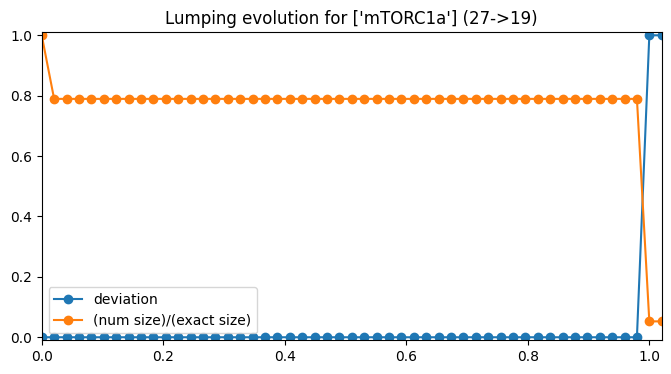

In [19]:
%time data = analysis_epsilon(get_example("BIOMD0000000448"))

### BIO...526 ($t_1 = 0.1$)

In [103]:
example = get_example("BIOMD0000000526")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 18
Initial state: |x_0| = 3836.0085453502315 ## |f(x_0)| = 2449.671993477863


#### Checking time for simulation

In [110]:
## Defining time frame
t0 = 0.0; t1 = 0.1; tstep = (t1-t0)/200; print(t1)

0.1


In [111]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 39.5 ms


CPU times: user 8.44 ms, sys: 8.92 ms, total: 17.4 ms
Wall time: 16.5 ms


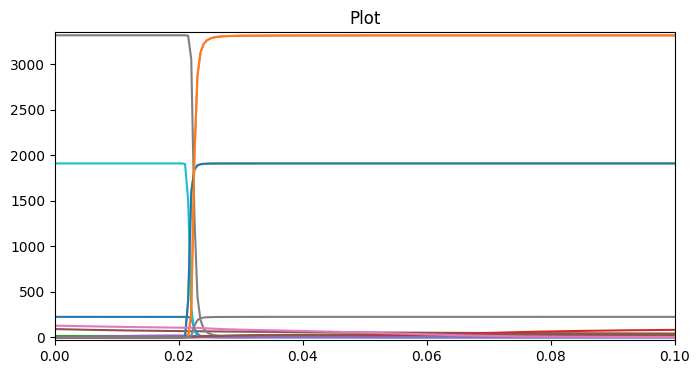

In [112]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 11:51:44 INFO     [analysis_epsilon # BIOMD0000000526] Starting epsilon analysis for BIOMD0000000526
2023-03-21 11:51:44 INFO     [analysis_epsilon # BIOMD0000000526] Building matrices for lumping...
2023-03-21 11:51:46 INFO     [analysis_epsilon # BIOMD0000000526] Building matrices for lumping...
2023-03-21 11:51:46 INFO     [analysis_epsilon # BIOMD0000000526] Processing bound for sampling...
2023-03-21 11:51:46 INFO     [analysis_epsilon # BIOMD0000000526] Computing data for [DISC]...
2023-03-21 11:51:46 WARNING  [construct_matrices] Method [polynomial] selected but input is not SparsePolynomial. Trying random...
2023-03-21 11:51:46 WARNING  [construct_matrices] Method [random] selected but input is not RationalFunction. Trying auto_diff...
2023-03-21 11:51:46 INFO     [analysis_epsilon # BIOMD0000000526] Generating graphics...
2023-03-21 11:51:46 INFO     [analysis_epsilon # BIOMD0000000526] Finidhes execution for BIOMD0000000526


CPU times: user 1.76 s, sys: 58 µs, total: 1.76 s
Wall time: 1.76 s


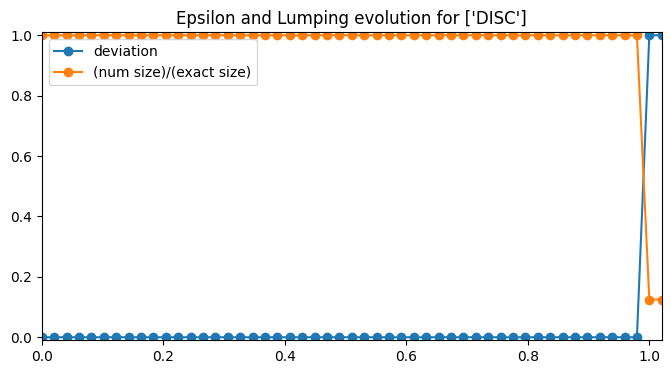

In [13]:
%time data = analysis_epsilon(get_example("BIOMD0000000526"))

### MODEL1502270000 (simulation and lumping slow)

In [3]:
example = get_example("MODEL1502270000")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 22
Initial state: |x_0| = 1000.0499987500625 ## |f(x_0)| = 651780122.0605216


#### Checking time for simulation

In [29]:
## Defining time frame
t0 = 0.0; t1 = 74/norm_fx0; tstep = (t1-t0)/200; print(t1)

1.1353522069077257e-07


In [30]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 23.2 ms


CPU times: user 17.8 ms, sys: 282 µs, total: 18.1 ms
Wall time: 17.7 ms


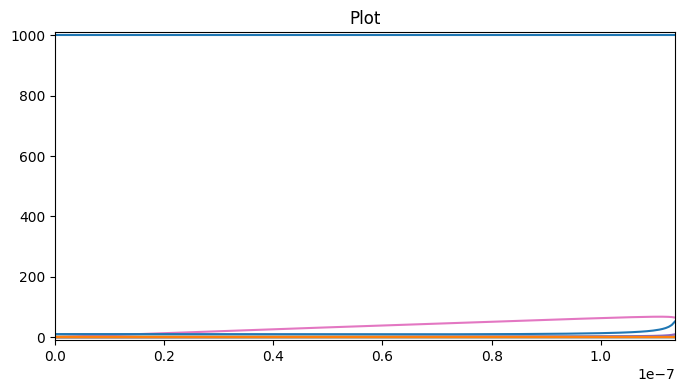

In [31]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

In [33]:
%time data = analysis_epsilon(get_example("MODEL1502270000")) # More than 55 mins

## New examples

### BIO...087 ($t_1 = 0.002$) 

In [2]:
example = get_example("BIOMD0000000087")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 55
Initial state: |x_0| = 13790.27574053543 ## |f(x_0)| = 1555390.888991556


#### Checking time for simulation

In [47]:
## Defining time frame
t0 = 0.0; t1 = 0.002; tstep = (t1-t0)/200; print(t1)

0.002


In [48]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 18.2 ms


In [56]:
apply_matrix?

Signature:
apply_matrix(
    simulation: scipy.integrate._ivp.ivp.OdeResult,
    matrix: numpy.ndarray | clue.linalg.SparseRowMatrix,
)
Docstring: <no docstring>
File:      ~/git/CLUE/clue/simulations.py
Type:      function


CPU times: user 12 ms, sys: 293 µs, total: 12.2 ms
Wall time: 11.6 ms


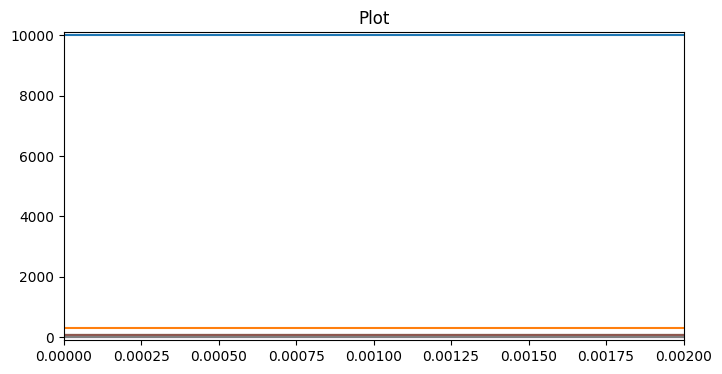

In [60]:
%time fig = create_figure(apply_matrix(simulation, exact_lumping.lumping_matrix), legend=False, format="-");

#### Checking the lumping for each observable

In [3]:
observable = [SparsePolynomial.from_string("Ctelo", system.variables)]
exact_lumping = system.lumping(observable, method="rational", print_reduction=False, print_system=False)
Lx0 = matmul(exact_lumping.lumping_matrix.to_numpy(dtype=x0.dtype), x0)
original_O = SparseRowMatrix.from_vectors([obs.linear_part_as_vec() for obs in observable])
O = SparseRowMatrix.from_vectors([exact_lumping._subspace.find_in(row) for row in original_O])

In [5]:
%time exact_lumping.is_consistent(how="numeric")

CPU times: user 8.65 ms, sys: 0 ns, total: 8.65 ms
Wall time: 8.62 ms


False

In [17]:
%debug

> /home/qh82kz/git/CLUE/clue/clue.py(717)<genexpr>()
    715         if how in ("symbolic", "exact"):
    716             Lx  = [sum(row[i]*x[i]  for i in row.nonzero) for row in x2y]
--> 717             Lfx = [sum(row[i]*fx[i] for i in row.nonzero) for row in x2y]
    718         else:
    719             Lx = matmul(x2y, x)



ipdb>  exit


In [45]:
X = uniform(size=(system.size,4))
norm(matmul(exact_lumping.lumping_matrix.to_numpy(dtype=X.dtype), system.derivative(...,X)) - exact_lumping.derivative(...,matmul(exact_lumping.lumping_matrix.to_numpy(dtype=X.dtype), X)))

0.0005280507861475218

In [23]:
from numpy import apply_along_axis

In [190]:
apply_along_axis(lambda v : system.derivative(...,v), 0, X).shape

(87, 2)

#### Checking maximal epsilons and deviations

2023-03-22 13:05:50 INFO     [analysis_epsilon # BIOMD0000000087] Starting epsilon analysis for BIOMD0000000087
2023-03-22 13:05:50 INFO     [analysis_epsilon # BIOMD0000000087] Building matrices for lumping...
2023-03-22 13:05:51 INFO     [analysis_epsilon # BIOMD0000000087] Building observables...
2023-03-22 13:05:51 INFO     [analysis_epsilon # BIOMD0000000087] Processing bound for sampling...
2023-03-22 13:05:51 INFO     [analysis_epsilon # BIOMD0000000087] Computing data for [Ctelo]...
2023-03-22 13:05:53 INFO     [analysis_epsilon # BIOMD0000000087] Computing data for [ssDNA]...
2023-03-22 13:05:55 INFO     [analysis_epsilon # BIOMD0000000087] Computing data for [Cdc13]...
2023-03-22 13:05:57 INFO     [analysis_epsilon # BIOMD0000000087] Generating graphics...
2023-03-22 13:05:57 INFO     [analysis_epsilon # BIOMD0000000087] Finidhes execution for BIOMD0000000087


CPU times: user 6.59 s, sys: 58.7 ms, total: 6.65 s
Wall time: 6.64 s


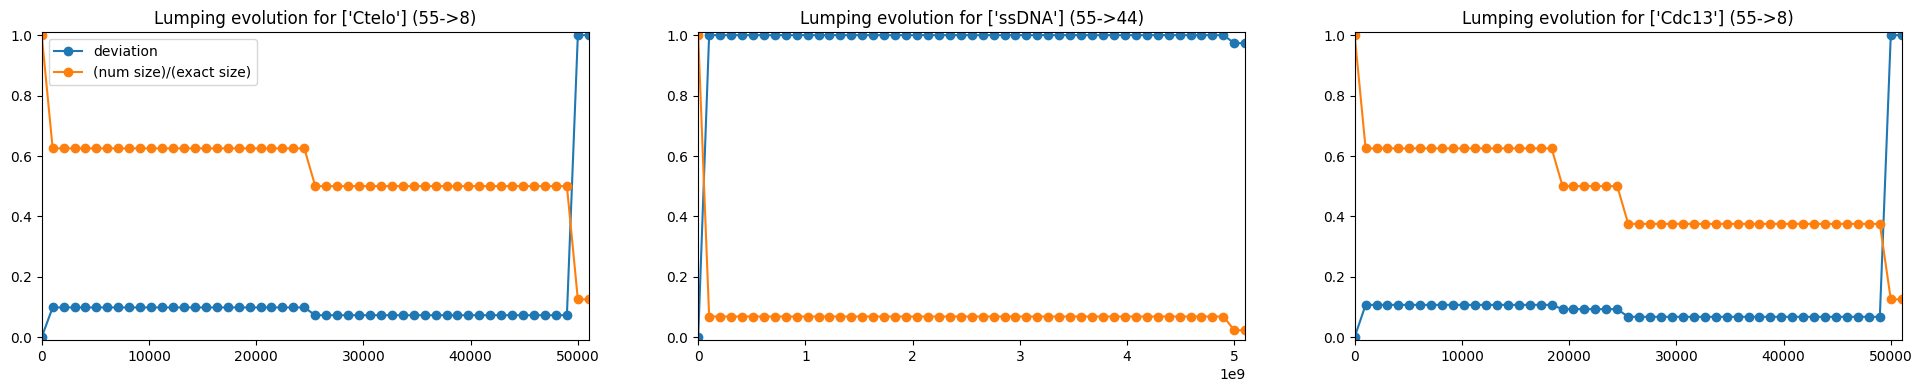

In [6]:
%time data = analysis_epsilon(get_example("BIOMD0000000087"))

In [14]:
data[0][0][-1]

(51020.40816326531,
 2.423716521526672e+20,
 <clue.linalg.NumericalSubspace at 0x7f7dce1ccd10>)

### BIO...088 ($t_1 = 10$)

In [8]:
example = get_example("BIOMD0000000088")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 104
Initial state: |x_0| = 4003.3813484801726 ## |f(x_0)| = 43.61178816616467


#### Checking time for simulation

In [12]:
## Defining time frame
t0 = 0.0; t1 = 10; tstep = (t1-t0)/200; print(t1)

10


In [13]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 51.5 s, sys: 19.2 ms, total: 51.6 s
Wall time: 51.5 s


CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 128 ms


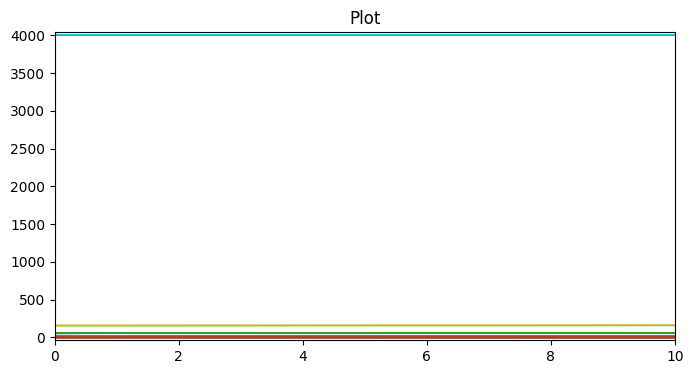

In [14]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-21 15:13:25 INFO     [analysis_epsilon # BIOMD0000000088] Starting epsilon analysis for BIOMD0000000088
2023-03-21 15:13:26 INFO     [analysis_epsilon # BIOMD0000000088] Building matrices for lumping...
2023-03-21 15:13:27 INFO     [analysis_epsilon # BIOMD0000000088] Building matrices for lumping...
2023-03-21 15:13:27 INFO     [analysis_epsilon # BIOMD0000000088] Processing bound for sampling...
2023-03-21 15:13:27 INFO     [analysis_epsilon # BIOMD0000000088] Computing data for [s360 + s359 + s358]...
2023-03-21 15:13:49 INFO     [analysis_epsilon # BIOMD0000000088] Computing data for [s135]...
2023-03-21 15:14:04 INFO     [analysis_epsilon # BIOMD0000000088] Computing data for [s124]...
2023-03-21 15:14:31 INFO     [analysis_epsilon # BIOMD0000000088] Computing data for [s467 + s470 + s477 + s480]...
2023-03-21 15:14:57 INFO     [analysis_epsilon # BIOMD0000000088] Generating graphics...
2023-03-21 15:14:57 INFO     [analysis_epsilon # BIOMD0000000088] Finidhes execution fo

CPU times: user 1min 32s, sys: 243 ms, total: 1min 32s
Wall time: 1min 32s


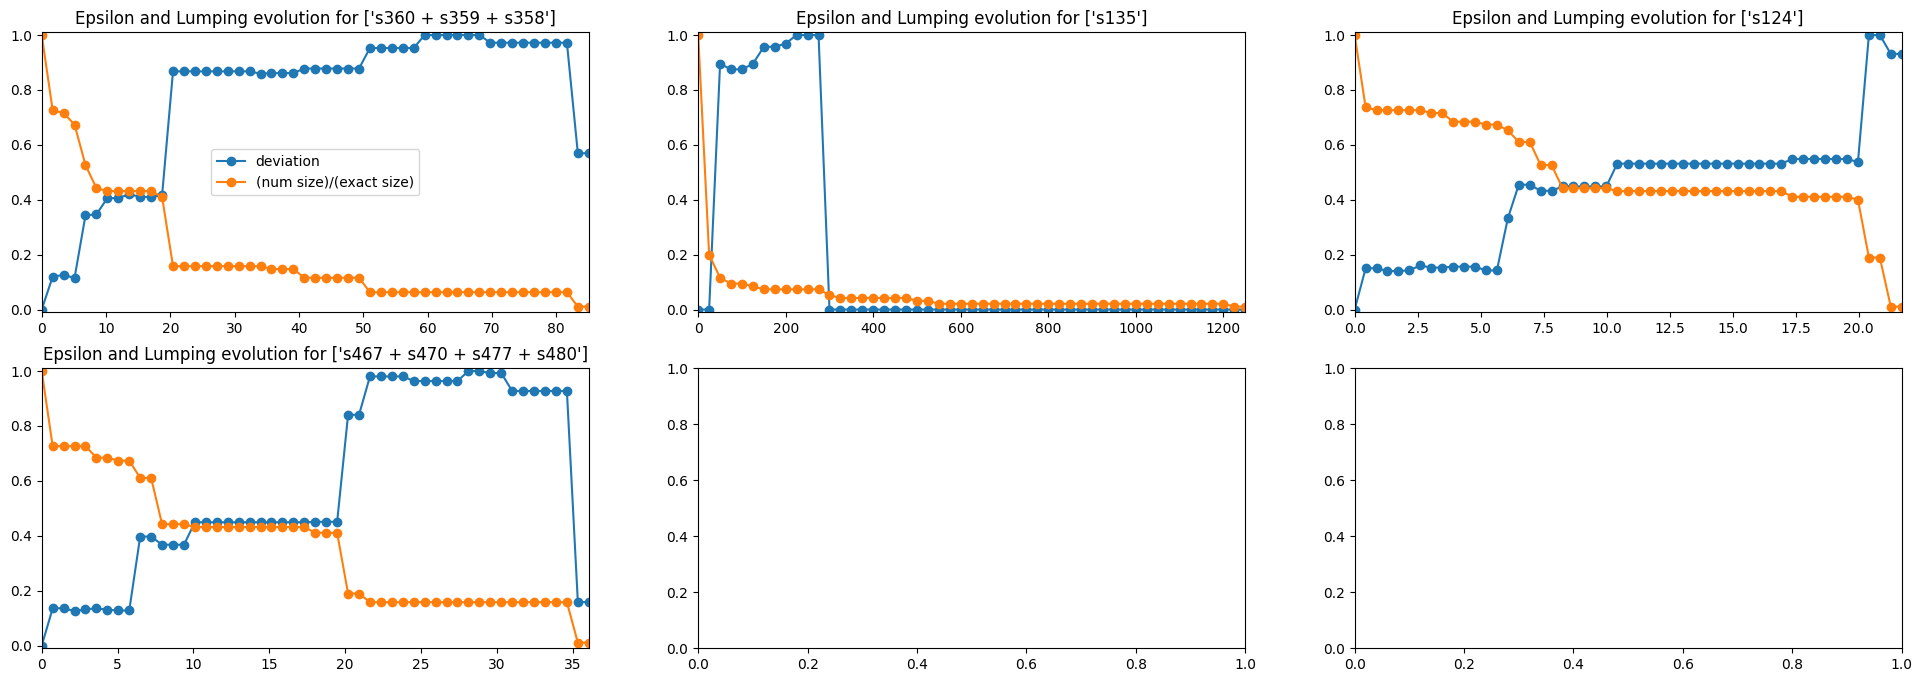

In [3]:
%time data = analysis_epsilon(get_example("BIOMD0000000088"))

### BIO...437 ($t_1 = 100$)

In [22]:
example = get_example("BIOMD0000000437")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 39
Initial state: |x_0| = 6.59694216700451 ## |f(x_0)| = 27.377731072619955


#### Checking time for simulation

In [16]:
## Defining time frame
t0 = 0.0; t1 = 100; tstep = (t1-t0)/200; print(t1)

100


In [17]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 20.5 ms, sys: 259 µs, total: 20.8 ms
Wall time: 20.1 ms


CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 26.2 ms


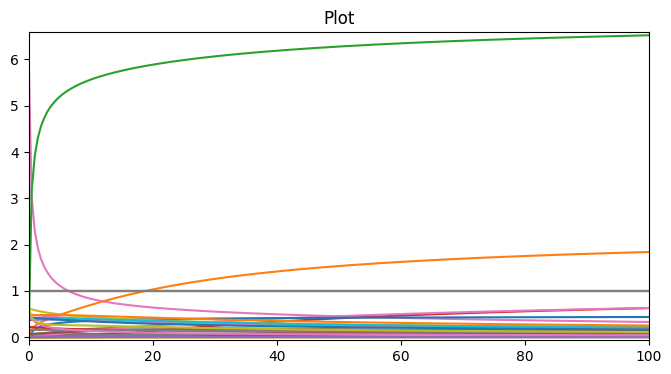

In [18]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-28 11:33:04 INFO     [analysis_epsilon # BIOMD0000000437] Starting epsilon analysis for BIOMD0000000437
2023-03-28 11:33:04 INFO     [analysis_epsilon # BIOMD0000000437] Building matrices for lumping...
2023-03-28 11:33:04 INFO     [analysis_epsilon # BIOMD0000000437] Building observables...
2023-03-28 11:33:04 INFO     [analysis_epsilon # BIOMD0000000437] Processing bound for sampling...
2023-03-28 11:33:04 INFO     [analysis_epsilon # BIOMD0000000437] Computing data for [frq_gene, frq_mRNA]...
2023-03-28 11:33:06 INFO     [analysis_epsilon # BIOMD0000000437] Computing data for [wc1_gene, wc1_mRNA]...
2023-03-28 11:33:08 INFO     [analysis_epsilon # BIOMD0000000437] Computing data for [wc2_gene, frq_gene, wc1_gene]...
2023-03-28 11:33:09 INFO     [analysis_epsilon # BIOMD0000000437] Generating graphics...
2023-03-28 11:33:09 INFO     [analysis_epsilon # BIOMD0000000437] Finidhes execution for BIOMD0000000437


CPU times: user 5.62 s, sys: 60 ms, total: 5.68 s
Wall time: 5.68 s


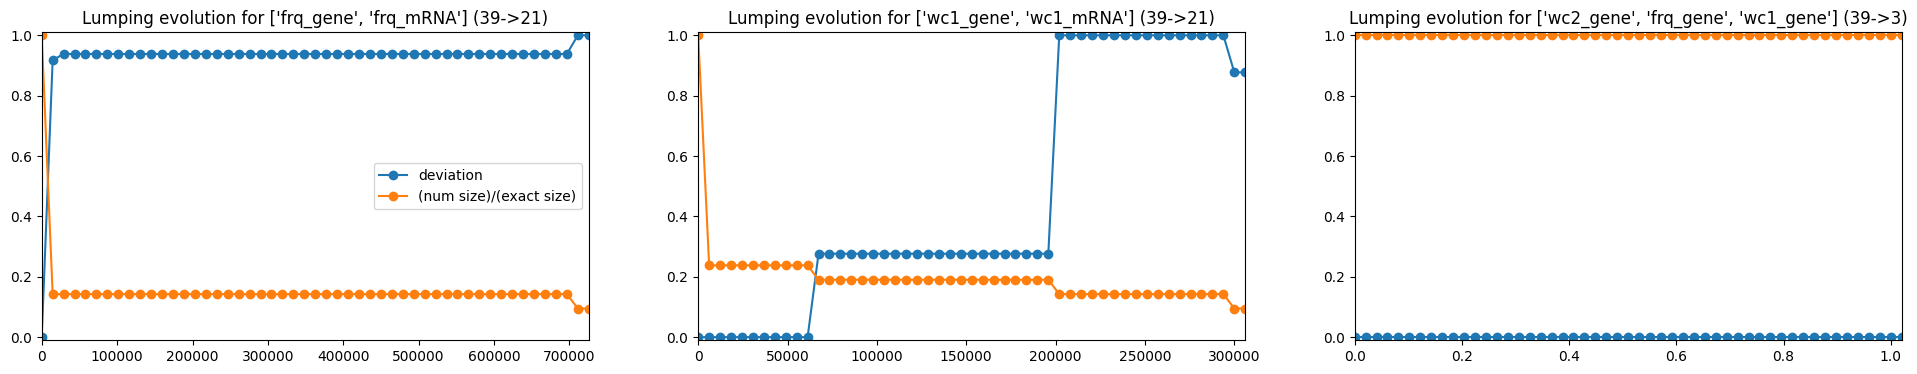

In [23]:
%time data = analysis_epsilon(get_example("BIOMD0000000437"))

### BIO...488 ($t_1 = 0.1$) (Simulation done by "LSODA")

In [24]:
example = get_example("BIOMD0000000488")
system = FODESystem(file=example.path_model(), read_ic = True, parser="rational").remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser="rational", field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 68
Initial state: |x_0| = 10893.657650210971 ## |f(x_0)| = 1.478016689125442e+24


#### Checking time for simulation

In [15]:
## Defining time frame
t0 = 0.0; t1 = 0.1; tstep = (t1-t0)/200; print(t1)

0.1


In [16]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep,method="LSODA")

CPU times: user 1.61 s, sys: 339 µs, total: 1.61 s
Wall time: 1.6 s


CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 102 ms


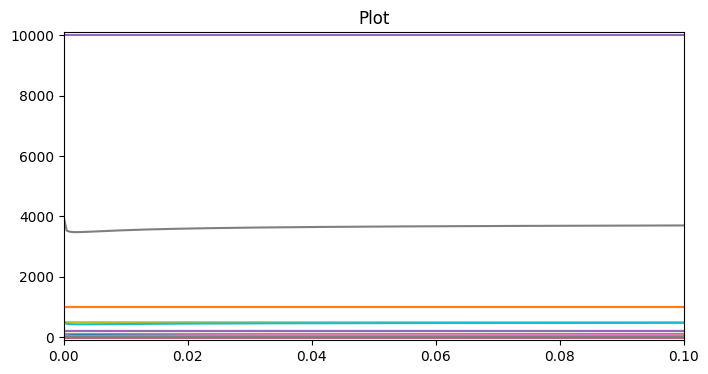

In [17]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-28 11:42:07 INFO     [analysis_epsilon # BIOMD0000000488] Starting epsilon analysis for BIOMD0000000488
2023-03-28 11:42:08 INFO     [analysis_epsilon # BIOMD0000000488] Building matrices for lumping...
2023-03-28 11:42:10 INFO     [analysis_epsilon # BIOMD0000000488] Building observables...
2023-03-28 11:42:10 INFO     [analysis_epsilon # BIOMD0000000488] Processing bound for sampling...
2023-03-28 11:42:10 INFO     [analysis_epsilon # BIOMD0000000488] Computing data for [GSK3b]...
2023-03-28 11:42:13 INFO     [analysis_epsilon # BIOMD0000000488] Computing data for [ROS]...
2023-03-28 11:42:21 INFO     [analysis_epsilon # BIOMD0000000488] Computing data for [Tau]...
2023-03-28 11:42:26 INFO     [analysis_epsilon # BIOMD0000000488] Computing data for [GSK3b, ROS, Tau]...
2023-03-28 11:42:30 INFO     [analysis_epsilon # BIOMD0000000488] Generating graphics...
2023-03-28 11:42:30 INFO     [analysis_epsilon # BIOMD0000000488] Finidhes execution for BIOMD0000000488


CPU times: user 23.4 s, sys: 190 ms, total: 23.6 s
Wall time: 23.5 s


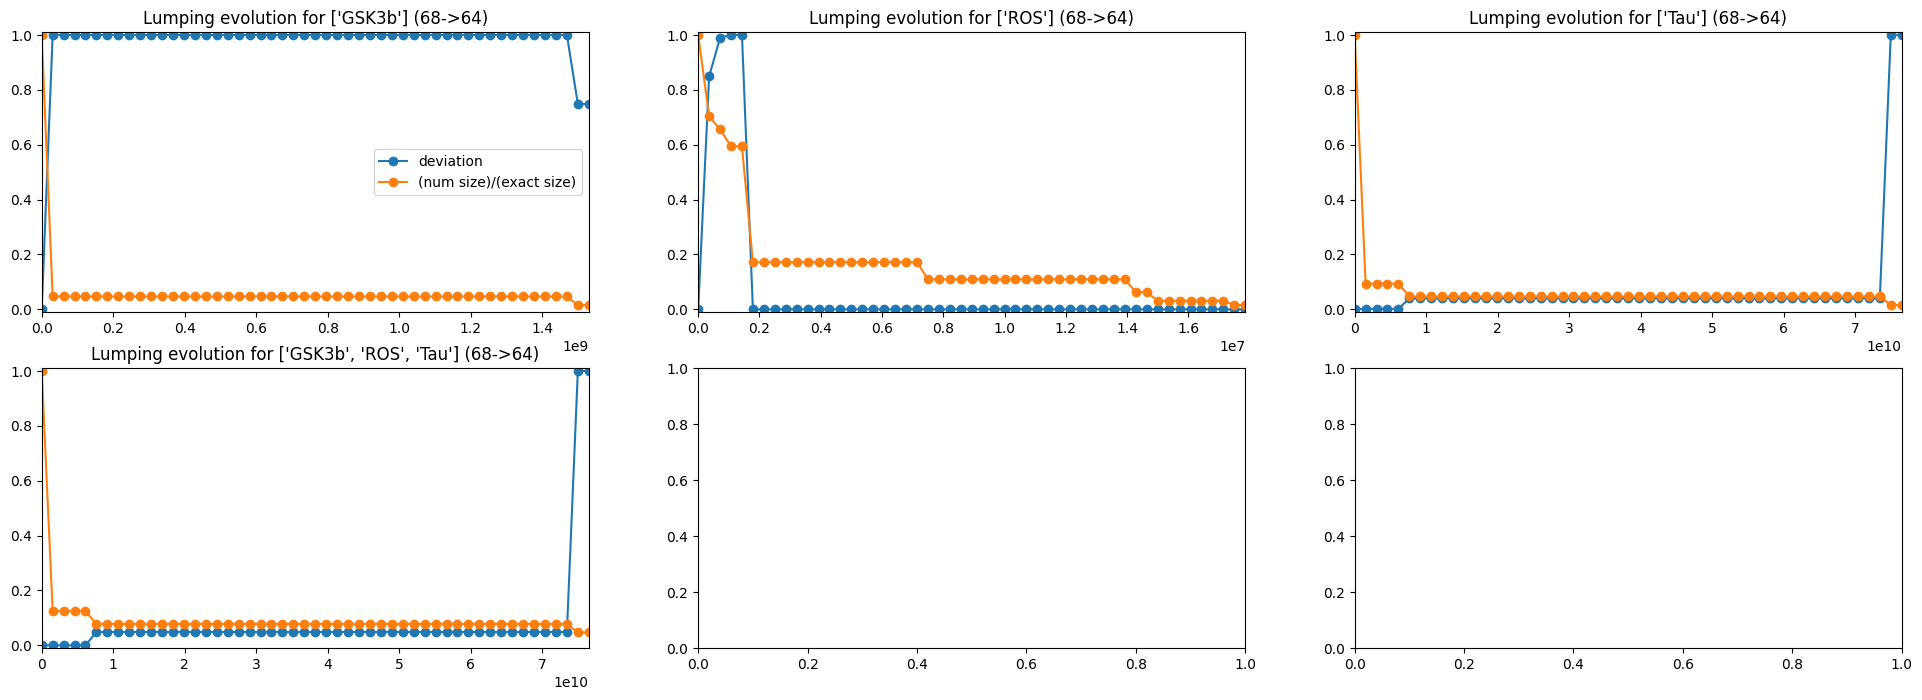

In [25]:
%time data = analysis_epsilon(get_example("BIOMD0000000488"))

### BIO...503 ($t_1 = 0.025$) (lumping matrices too slow)

In [34]:
example = get_example("BIOMD0000000503")
system = FODESystem(file=example.path_model(), read_ic = True, parser="sympy").remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser="sympy", field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 75
Initial state: |x_0| = 323.3606443899626 ## |f(x_0)| = 15142.174315139167


#### Checking time for simulation

In [16]:
## Defining time frame
t0 = 0.0; t1 = 0.025; tstep = (t1-t0)/200; print(t1)

0.025


In [17]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 26 ms, sys: 9.84 ms, total: 35.9 ms
Wall time: 37 ms


CPU times: user 31.2 ms, sys: 2.97 ms, total: 34.2 ms
Wall time: 32.9 ms


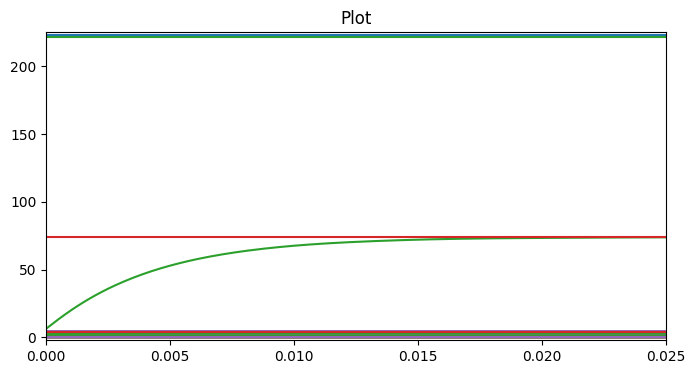

In [18]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

In [38]:
%time data = analysis_epsilon(get_example("BIOMD0000000503"))

### BIO...535 ($t_1 = 0.015$)  (Lumping is not working?)

In [3]:
example = get_example("BIOMD0000000535")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 41
Initial state: |x_0| = 492.1368651483341 ## |f(x_0)| = 2237754062.776994


#### Checking time for simulation

In [10]:
## Defining time frame
t0 = 0.0; t1 = 0.015; tstep = (t1-t0)/200; print(t1)

0.015


In [11]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 1.53 s


CPU times: user 18.2 ms, sys: 7.75 ms, total: 25.9 ms
Wall time: 24.9 ms


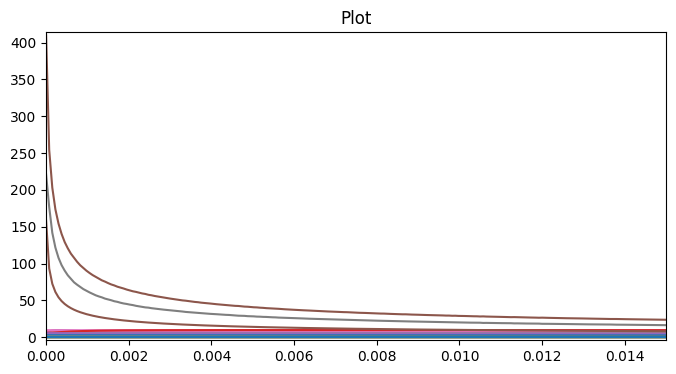

In [12]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-22 14:09:53 INFO     [analysis_epsilon # BIOMD0000000535] Starting epsilon analysis for BIOMD0000000535
2023-03-22 14:09:54 INFO     [analysis_epsilon # BIOMD0000000535] Building matrices for lumping...
2023-03-22 14:10:08 INFO     [analysis_epsilon # BIOMD0000000535] Building observables...
2023-03-22 14:10:08 INFO     [analysis_epsilon # BIOMD0000000535] Processing bound for sampling...
2023-03-22 14:10:08 INFO     [analysis_epsilon # BIOMD0000000535] Computing data for [mw114aa90f_5f5b_4fe8_9406_361c8489b6a1 + mwd5313618_89eb_4c8c_bc82_66f10f966349, mw39c2e431_fdc3_4964_be29_6ca856620b1b + mw48867e93_f170_44e8_ac7a_185b23e1bf3b, mwf626e95e_543f_41e4_aad4_c6bf60ab345b + mw0adf3eb4_a196_4c48_b10d_4e9e9faaf9e1 + mw2c9b0499_3325_4394_8af3_bbf653a944a0, mw03db56ac_8dc6_4931_ae82_fef706d2ee3d + mw4638f126_8cb8_4021_ab41_6ae195743ba0 + mw7becb5fe_8da8_4285_a821_0d77ad811b62]...
2023-03-22 14:15:29 INFO     [analysis_epsilon # BIOMD0000000535] Generating graphics...
2023-03-22 14:15

CPU times: user 5min 35s, sys: 180 ms, total: 5min 35s
Wall time: 5min 35s


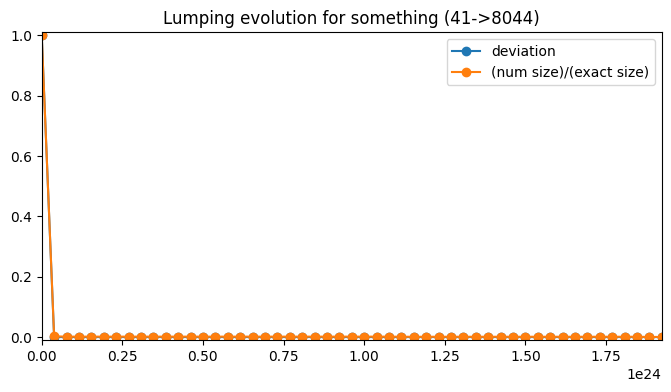

In [3]:
%time data = analysis_epsilon(get_example("BIOMD0000000535"))

### BIO...537 ($t_1 = 0.015$) (Lumping is not working?)

In [3]:
example = get_example("BIOMD0000000537")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 42
Initial state: |x_0| = 492.13686514833404 ## |f(x_0)| = 2237754062.7769933


#### Checking time for simulation

In [14]:
## Defining time frame
t0 = 0.0; t1 = 0.015; tstep = (t1-t0)/200; print(t1)

0.015


In [15]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.8 s


CPU times: user 14.4 ms, sys: 9.18 ms, total: 23.6 ms
Wall time: 22.6 ms


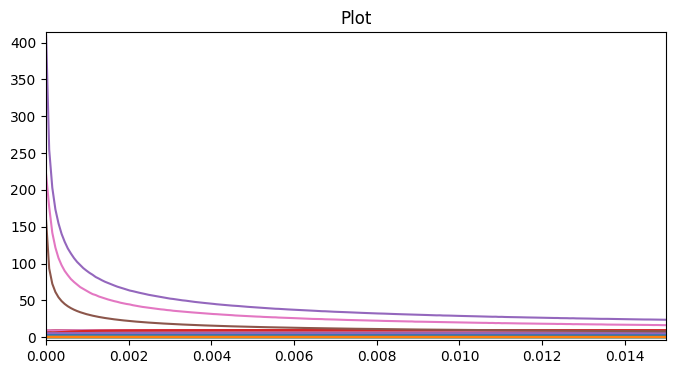

In [16]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

In [5]:
%time data = analysis_epsilon(get_example("BIOMD0000000537"))

### BIO...611 ($t_1 = 100$ --> constant system?) 

In [15]:
example = get_example("BIOMD0000000611")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 65
Initial state: |x_0| = 9740.604074698089 ## |f(x_0)| = 0.0


#### Checking time for simulation

In [20]:
## Defining time frame
t0 = 0.0; t1 = 100; tstep = (t1-t0)/200; print(t1)

100


In [21]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep)

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 18.8 ms


CPU times: user 28.5 ms, sys: 148 µs, total: 28.6 ms
Wall time: 27.4 ms


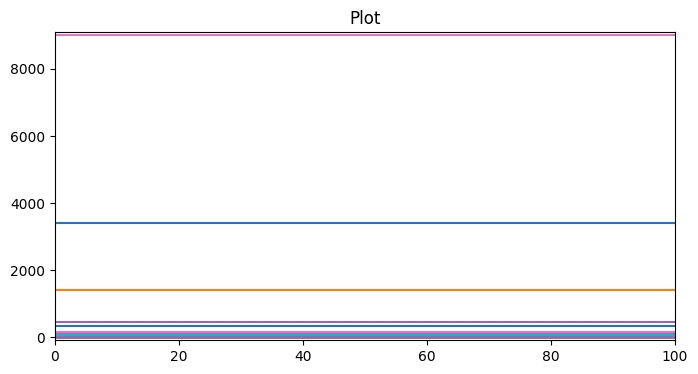

In [22]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-22 13:34:16 INFO     [analysis_epsilon # BIOMD0000000611] Starting epsilon analysis for BIOMD0000000611
2023-03-22 13:34:16 INFO     [analysis_epsilon # BIOMD0000000611] Building matrices for lumping...
2023-03-22 13:34:17 INFO     [analysis_epsilon # BIOMD0000000611] Building observables...
2023-03-22 13:34:17 INFO     [analysis_epsilon # BIOMD0000000611] Processing bound for sampling...
2023-03-22 13:34:17 INFO     [analysis_epsilon # BIOMD0000000611] Computing data for [mwfa9d903a_b5e5_4a38_a649_dfe4719577aa]...
2023-03-22 13:34:20 INFO     [analysis_epsilon # BIOMD0000000611] Generating graphics...
2023-03-22 13:34:20 INFO     [analysis_epsilon # BIOMD0000000611] Finidhes execution for BIOMD0000000611


CPU times: user 3.41 s, sys: 9.6 ms, total: 3.42 s
Wall time: 3.41 s


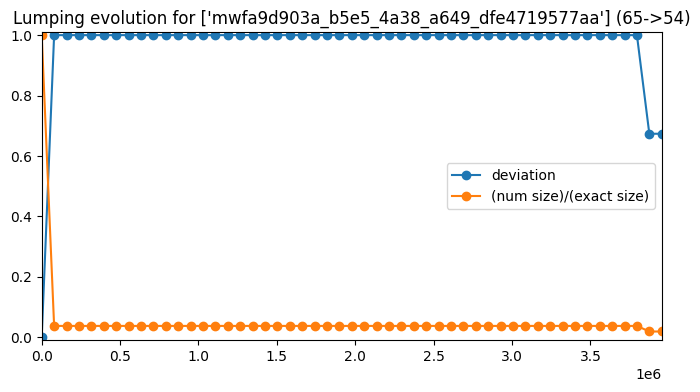

In [19]:
%time data = analysis_epsilon(get_example("BIOMD0000000611"))

### BIO...634 ($t_1 = 0.00025$) 

In [3]:
example = get_example("BIOMD0000000634")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
norm_x0 = norm(x0, ord=2)
fx0 = array(RRsystem.derivative(..., *x0), dtype=x0.dtype)
norm_fx0 = norm(fx0, ord=2)
print(f"Original system size: {RRsystem.size}")
print(f"Initial state: |x_0| = {norm_x0} ## |f(x_0)| = {norm_fx0}")

Original system size: 68
Initial state: |x_0| = 10893.657650210971 ## |f(x_0)| = 1.478016689125442e+24


#### Checking time for simulation

In [11]:
## Defining time frame
t0 = 0.0; t1 = 0.00025; tstep = (t1-t0)/200; print(t1)

0.00025


In [12]:
%time simulation = RRsystem.simulate(t0,t1,x0,tstep,method="LSODA")

CPU times: user 1.46 s, sys: 40 µs, total: 1.46 s
Wall time: 1.46 s


CPU times: user 33.9 ms, sys: 4.91 ms, total: 38.9 ms
Wall time: 37.8 ms


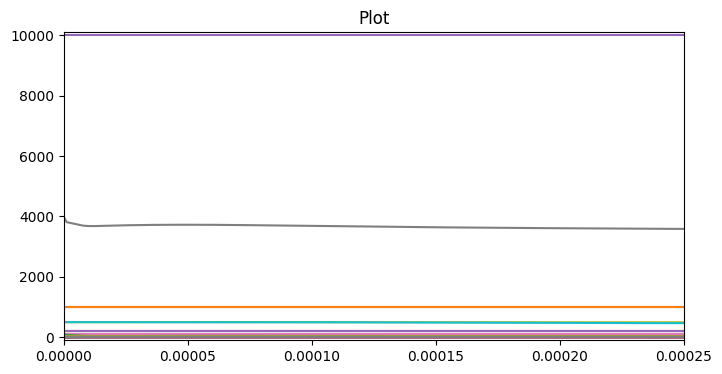

In [13]:
%time fig = create_figure(simulation, legend=False, format="-");

#### Checking maximal epsilons and deviations

2023-03-22 13:32:58 INFO     [analysis_epsilon # BIOMD0000000634] Starting epsilon analysis for BIOMD0000000634
2023-03-22 13:32:59 INFO     [analysis_epsilon # BIOMD0000000634] Building matrices for lumping...
2023-03-22 13:33:00 INFO     [analysis_epsilon # BIOMD0000000634] Building observables...
2023-03-22 13:33:00 INFO     [analysis_epsilon # BIOMD0000000634] Processing bound for sampling...
2023-03-22 13:33:00 INFO     [analysis_epsilon # BIOMD0000000634] Computing data for [GSK3b]...
2023-03-22 13:33:04 INFO     [analysis_epsilon # BIOMD0000000634] Computing data for [ROS]...
2023-03-22 13:33:11 INFO     [analysis_epsilon # BIOMD0000000634] Computing data for [Tau]...
2023-03-22 13:33:15 INFO     [analysis_epsilon # BIOMD0000000634] Computing data for [GSK3b, ROS, Tau]...
2023-03-22 13:33:19 INFO     [analysis_epsilon # BIOMD0000000634] Generating graphics...
2023-03-22 13:33:19 INFO     [analysis_epsilon # BIOMD0000000634] Finidhes execution for BIOMD0000000634


CPU times: user 21.2 s, sys: 159 ms, total: 21.4 s
Wall time: 21.4 s


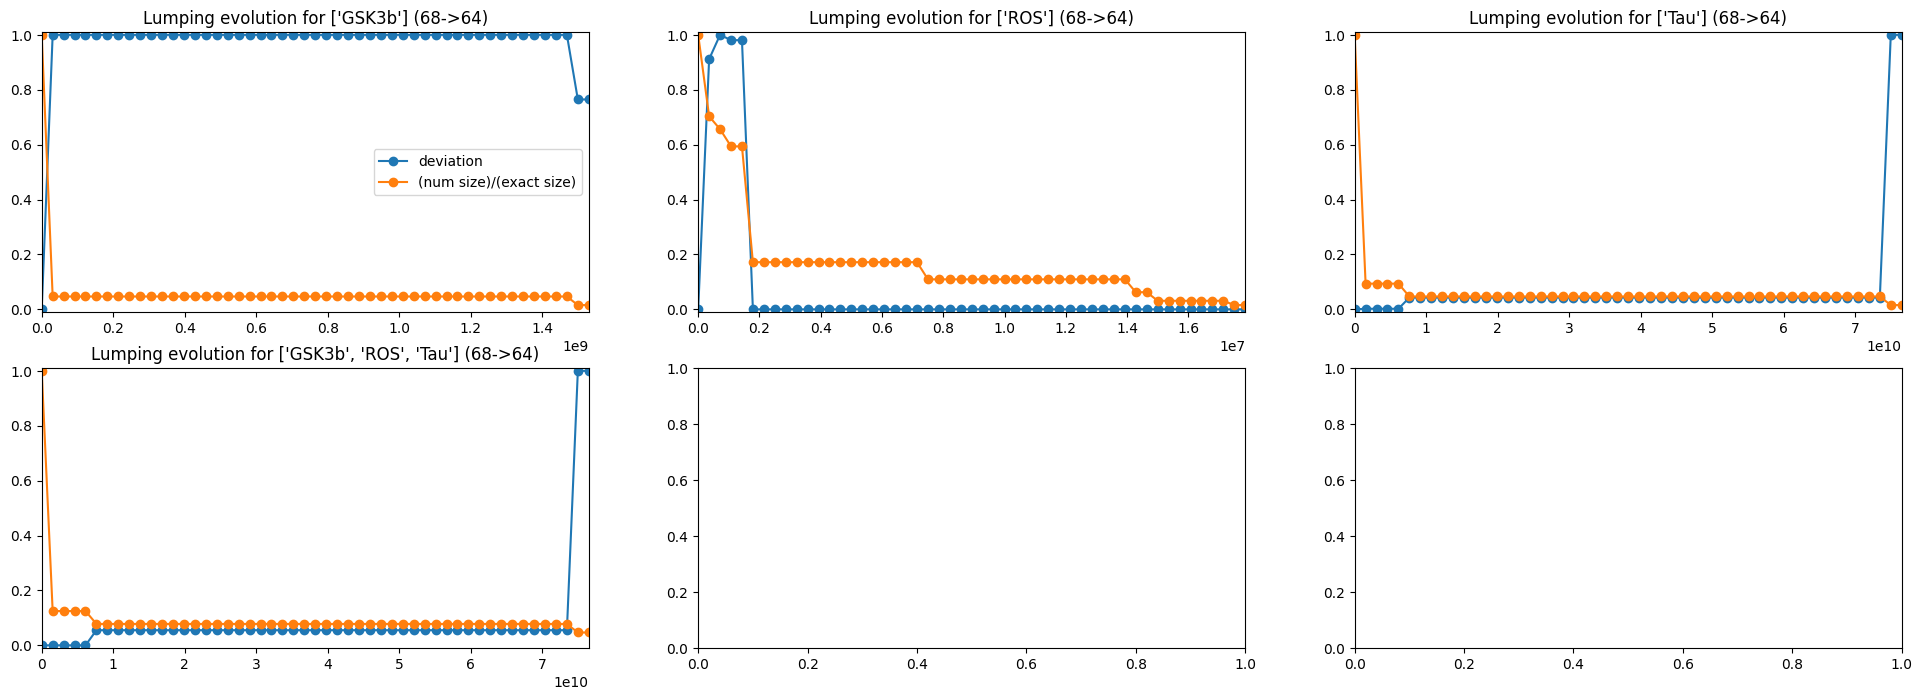

In [14]:
%time data = analysis_epsilon(get_example("BIOMD0000000634"))